<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/Genetic_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic Program 

In [1]:
!pip install deap
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install skfeature-chappers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data

Predicting the majority class would be 0.44 accurate. Error would be 0.56.


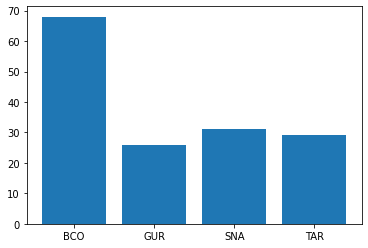

In [2]:
"""
Data - data.py
==============

This is the data module. It contains the functions for loading, preparing, normalizing and encoding the data.
"""

import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import scipy.io

def encode_labels(y, y_test=None):
    """
    Convert text labels to numbers.

    Args:
        y: The labels.
        y_test: The test labels. Defaults to None.
    """
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    if y_test is not None:
        y_test = le.transform(y_test)
    return y, y_test, le

def load(filename, folder=''):
    """
    Load the data from the mat file.

    Args:
        filename: The name of the mat file.
        folder: The folder where the mat file is located.
    """
    path = folder + filename
    mat = scipy.io.loadmat(path)
    return mat

def prepare(mat):
    """
    Load the data from matlab format into memory. 

    Args:
        mat: The data in matlab format.
    """
    X = mat['X']   
    X = X.astype(float)
    y = mat['Y']    
    y = y[:, 0]
    return X,y

def normalize(X_train, X_test):
    """
    Normalize the input features within range [0,1].

    Args:
        X_train: The training data.
        X_test: The test data.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

file = load('Fish.mat')
X,y = prepare(file)
X,_ = normalize(X,X)
y, _, le = encode_labels(y)
labels = le.inverse_transform(np.unique(y))
n_features = X.shape[1]
n_instances = X.shape[0]

import matplotlib.pyplot as plt
from collections import Counter
counts = Counter(y)

cts = []
for label in np.unique(y): 
    cts.append(list(y).count(label))

plt.bar(labels, cts)
p = (cts[0] / n_instances)
e = 1 - p
print(f"Predicting the majority class would be {p:.2f} accurate. Error would be {e:.2f}.")

## Feature Selection

In [3]:
from skfeature.function.information_theoretical_based import MRMR
from sklearn.feature_selection import chi2, SelectKBest

k = 1500
fs = SelectKBest(MRMR.mrmr, k=k)
X = fs.fit_transform(X, y)
# Update feature number. 
n_features = X.shape[1]
classes = np.unique(y)
n_classes = len(classes)
print(f"Number of features: {n_features}\nNumber of instances: {n_instances}\nNumber of classes {n_classes}.")

Number of features: 1500
Number of instances: 154
Number of classes 4.


## Genetic Program

In [4]:
""" 
Genetic Program - gp.py 
=======================

An implementation of a Genetic Program (Koza 1994), a simple GP tree with elitism and a classification map (CM) (Smart 2005) for multi-class classification. 

References:
1. Koza, J. R. (1994). Genetic programming as a means for programming 
    computers by natural selection. Statistics and computing, 4(2), 87-112.
2. Smart, W., & Zhang, M. (2005, March). Using genetic programming for 
    multiclass classification by simultaneously solving component binary 
    classification problems. In European Conference on Genetic Programming 
    (pp. 227-239). Springer, Berlin, Heidelberg.
"""
import math
import random
import operator
import csv
import itertools

import numpy as np

from deap import algorithms
from deap.algorithms import varAnd
from deap import base
from deap import creator
from deap import tools
from deap import gp


def protectedDiv(left, right):
    """
    Protected division operator that avoids zero division.

    Arg:
        left: The left hand side expression. 
        right: The right hand side expression. 

    Returns: 
        left/right, when right is non-zero value. Otherwise, returns 1. 
    """
    try:
        return left / right
    except ZeroDivisionError:
        return 1


def if_then_else(condition, left, right):
    """
    The if then else operator allows for conditional branching within the GP tree. 
    Conditional logic allows for more complex program structures to emerge.

    Args: 
        condition: The expression which determines the chosen branch.
        left: The left branch, taken if condition is positive.
        right: The right branch is returned if condition is negative.

    Return: 
        left, if condition is postive. Otherwise, right. 
    """
    if condition > 0: 
        return left 
    else: 
        return right 

pset = gp.PrimitiveSet("MAIN", n_features)

# Arithmetic Operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
# pset.addPrimitive(if_then_else, 3)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

# Weight=(-1.0,) for minimization. Weight=(1.0,) for maximization. 
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def classification_map(x, y):
    n_classes = len(np.unique(y))

    return 1

def classification_map(y_pred):
    """ 
    Maps a float to a classification label using a classification map (Smart 2005).

    This variation situates class regions sequentially on the floating point number line. 
    The object image will be classified to the class of the region that the program output with
    the object image input falls into. Class region boundaries start at some negative
    number, and end at the same positive number. Boundaries between the starting point and the 
    end point are allocated with an identical interval of 1.0

    Args:
        y_pred (float): The floating point prediction on the floating point number line. 

    Returns:
        y_pred (int): The predicted class. 

    References:
        1. Smart, W., & Zhang, M. (2005, March). Using genetic programming for multiclass 
        classification by simultaneously solving component binary classification problems. 
        In European Conference on Genetic Programming (pp. 227-239). Springer, Berlin, Heidelberg.
    """
    a = [float('-inf'), -2, -1, 1, float('inf')]
    for i, (a,b) in enumerate(zip(a, a[1:])):
        if y_pred > a and y_pred < b:
            return i 

def evaluate_classification(individual):
    """ 
    Evalautes the fitness of an individual by its classification accuracy. 

    Args:  
        individual: A candidate solution to be evaluated. 

    Returns: 
        error: A fraction of incorrectly classified instances. 
    """
    func = toolbox.compile(expr=individual)
    acc = sum(classification_map(func(*x)) == y_ for x,y_ in zip(X,y)) / n_instances 
    error = 1 - acc 
    return error,

toolbox.register("evaluate", evaluate_classification)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


def SimpleGPWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """
    A variation of the eaSimple method from the DEAP library that allows for elitism. 

    Elitism ensures the best individuals (the elite) from each generation are 
    carried onto the next without alteration. This ensures the quality of the 
    best solution monotonically increases over time. 
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    
    if verbose:
        print(logbook.stream)

    for gen in range(1, ngen + 1):
        offspring = toolbox.select(population, len(population) - hof_size)
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        offspring.extend(halloffame.items)
        halloffame.update(offspring)
        population[:] = offspring
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        if verbose:
            print(logbook.stream)

    return population, logbook

def main(generations=100, population=100, elitism=0.1, crossover_rate=0.5, mutation_rate=0.1):
    """
    This is a SimpleGA with Elitism and a Classification Map (CM) for Multi-class classification. 

    Args:
        generations: The number of generations to evolve the populaiton for. 
        elitism: The ratio of elites to be kept between generations. 
        crossover_rate: The probability of a crossover between two individuals. 
        mutation_rate: The probability of a random mutation within an individual.  

    Returns:
        pop: The final population the algorithm has evolved. 
        log: The logbook which can record important statistics. 
        hof: The hall of fame contains the best individual solutions.
    """

    random.seed(420)
    pop = toolbox.population(n=population)
    
    mu = round(elitism * population)
    if elitism > 0:
        hof = tools.HallOfFame(mu)
    else:
        hof = None
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = SimpleGPWithElitism(pop, toolbox, crossover_rate, mutation_rate, generations, stats=mstats,
                                   halloffame=hof, verbose=True)
    # print log
    return pop, log, hof

generations = 300
population = 100
elitism = 0.1
crossover_rate = 0.5
mutation_rate = 0.1
pop, log, hof = main(generations, population, elitism, crossover_rate, mutation_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars


   	      	                                 fitness                                 	                      size                     
   	      	-------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std      	avg 	gen	max	min	nevals	std    
0  	100   	0.812273	0  	0.909091	0.727273	100   	0.0285433	3.39	0  	7  	2  	100   	1.35569
1  	43    	0.795065	1  	0.87013 	0.720779	43    	0.0249357	3.45	1  	7  	1  	43    	1.4586 
2  	59    	0.788247	2  	0.896104	0.655844	59    	0.0296561	3.86	2  	9  	1  	59    	1.70306
3  	58    	0.775909	3  	1       	0.655844	58    	0.0480651	4.48	3  	9  	1  	58    	1.95182
4  	42    	0.758442	4  	1       	0.655844	42    	0.0587582	5.61	4  	13 	1  	42    	2.2755 
5  	60    	0.75013 	5  	1       	0.61039 	60    	0.0783133	6.25	5  	13 	3  	60    	2.24221
6  	45    	0.722468	6  	1       	0.577922	45    	0.0757078	7.29	6  	15 	3  	45    	2.46696
7  	50

## Visualization

In [5]:
from deap import base, creator, gp
import pygraphviz as pgv

expr = hof[0]
nodes, edges, labels = gp.graph(expr)

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")